<h1> 2. Creating a sampled dataset </h1>

This notebook illustrates:
<ol>
<li> Sampling a BigQuery dataset to create datasets for ML
<li> Preprocessing with Pandas
</ol>

In [4]:
# change these to try this notebook out
BUCKET = 'qw-gcp-a52a89d78c80969a'
PROJECT = 'qwiklabs-gcp-a52a89d78c80969a'
REGION = 'europe-west1'

In [ ]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [ ]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h2> Create ML dataset by sampling using BigQuery </h2>
<p>
Let's sample the BigQuery data to create smaller datasets.
</p>

In [5]:
# Create SQL query using natality data after the year 2000
from google.cloud import bigquery
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

There are only a limited number of years and months in the dataset. Let's see what the hashmonths are.

In [6]:
# Call BigQuery but GROUP BY the hashmonth and see number of records for each group to enable us to get the correct train and evaluation percentages
df = bigquery.Client().query("SELECT hashmonth, COUNT(weight_pounds) AS num_babies FROM (" + query + ") GROUP BY hashmonth").to_dataframe()
print("There are {} unique hashmonths.".format(len(df)))
df.head()

There are 96 unique hashmonths.


,hashmonth,num_babies
0,7170969733900686954,331274
1,7146494315947640619,335327
2,1403073183891835564,351299
3,3545707052733304728,327823
4,1451354159195218418,334485


Here's a way to get a well distributed portion of the data in such a way that the test and train sets do not overlap:

In [7]:
# Added the RAND() so that we can now subsample from each of the hashmonths to get approximately the record counts we want
trainQuery = "SELECT * FROM (" + query + ") WHERE MOD(hashmonth, 4) < 3 AND RAND() < 0.0005"
evalQuery = "SELECT * FROM (" + query + ") WHERE MOD(hashmonth, 4) = 3 AND RAND() < 0.0005"
traindf = bigquery.Client().query(trainQuery).to_dataframe()
evaldf = bigquery.Client().query(evalQuery).to_dataframe()
print("There are {} examples in the train dataset and {} in the eval dataset".format(len(traindf), len(evaldf)))

There are 13301 examples in the train dataset and 3345 in the eval dataset


<h2> Preprocess data using Pandas </h2>
<p>
Let's add extra rows to simulate the lack of ultrasound. In the process, we'll also change the plurality column to be a string.

In [8]:
traindf.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.936641,False,39,1,42.0,774501970389208065
1,5.937049,False,19,1,38.0,774501970389208065
2,6.563162,False,16,1,37.0,774501970389208065
3,6.228059,False,21,1,39.0,774501970389208065
4,7.874912,True,21,1,42.0,774501970389208065


Also notice that there are some very important numeric fields that are missing in some rows (the count in Pandas doesn't count missing data)

In [9]:
# Let's look at a small sample of the training data
traindf.describe()

,weight_pounds,mother_age,plurality,gestation_weeks,hashmonth
count,13293.000000,13301.000000,13301.000000,13213.000000,1.330100e+04
mean,7.225997,27.370198,1.033080,38.607432,4.386641e+18
std,1.327218,6.121226,0.186669,2.599820,2.807723e+18
min,0.500449,13.000000,1.000000,17.000000,1.244589e+17
25%,6.563162,22.000000,1.000000,38.000000,1.622638e+18
50%,7.312733,27.000000,1.000000,39.000000,4.329667e+18
75%,8.062305,32.000000,1.000000,40.000000,7.170970e+18
max,13.126323,53.000000,4.000000,47.000000,9.183606e+18


In [10]:
# It is always crucial to clean raw data before using in ML, so we have a preprocessing step
import pandas as pd
def preprocess(df):
  # clean up data we don't want to train on
  # in other words, users will have to tell us the mother's age
  # otherwise, our ML service won't work.
  # these were chosen because they are such good predictors
  # and because these are easy enough to collect
  df = df[df.weight_pounds > 0]
  df = df[df.mother_age > 0]
  df = df[df.gestation_weeks > 0]
  df = df[df.plurality > 0]
  
  # modify plurality field to be a string
  twins_etc = dict(zip([1,2,3,4,5],
                   ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)']))
  df['plurality'].replace(twins_etc, inplace=True)
  
  # now create extra rows to simulate lack of ultrasound
  nous = df.copy(deep=True)
  nous.loc[nous['plurality'] != 'Single(1)', 'plurality'] = 'Multiple(2+)'
  nous['is_male'] = 'Unknown'
  
  return pd.concat([df, nous])

In [11]:
traindf.head()# Let's see a small sample of the training data now after our preprocessing
traindf = preprocess(traindf)
evaldf = preprocess(evaldf)
traindf.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.936641,False,39,Single(1),42.0,774501970389208065
1,5.937049,False,19,Single(1),38.0,774501970389208065
2,6.563162,False,16,Single(1),37.0,774501970389208065
3,6.228059,False,21,Single(1),39.0,774501970389208065
4,7.874912,True,21,Single(1),42.0,774501970389208065


In [24]:
traindf.tail()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
13184,6.999677,Unknown,32,Single(1),40.0,6637442812569910270
13185,5.546831,Unknown,38,Single(1),35.0,6637442812569910270
13186,7.286278,Unknown,34,Single(1),40.0,6637442812569910270
13187,7.561856,Unknown,26,Single(1),39.0,6637442812569910270
13188,6.217036,Unknown,19,Single(1),36.0,6637442812569910270


In [52]:
traindf.describe()

,weight_pounds,mother_age,gestation_weeks,hashmonth
count,26158.000000,26158.000000,26158.000000,2.615800e+04
mean,7.222043,27.454087,38.599052,4.413848e+18
std,1.327512,6.145750,2.590407,2.806117e+18
min,0.500449,13.000000,18.000000,1.244589e+17
25%,6.563162,23.000000,38.000000,1.525201e+18
50%,7.312733,27.000000,39.000000,4.329667e+18
75%,8.062305,32.000000,40.000000,7.170970e+18
max,12.251088,50.000000,47.000000,9.183606e+18


/usr/local/envs/py3env/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


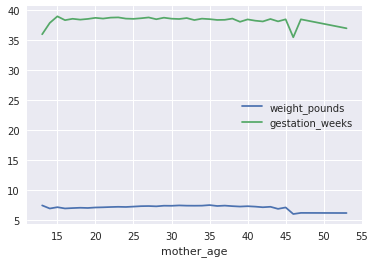

In [12]:
traindf.groupby("mother_age").mean().plot(y=["weight_pounds",'gestation_weeks']);

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


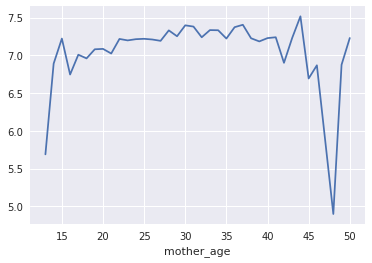

In [42]:
t_to_plot['weight_pounds'].plot();

In [13]:
# Describe only does numeric columns, so you won't see plurality
traindf.describe()

,weight_pounds,mother_age,gestation_weeks,hashmonth
count,26418.000000,26418.000000,26418.000000,2.641800e+04
mean,7.225579,27.369899,38.611326,4.383263e+18
std,1.328641,6.115967,2.586060,2.807281e+18
min,0.500449,13.000000,18.000000,1.244589e+17
25%,6.563162,22.000000,38.000000,1.525201e+18
50%,7.312733,27.000000,39.000000,4.329667e+18
75%,8.062305,32.000000,40.000000,7.108882e+18
max,13.126323,53.000000,47.000000,9.183606e+18


<h2> Write out </h2>
<p>
In the final versions, we want to read from files, not Pandas dataframes. So, write the Pandas dataframes out as CSV files. 
Using CSV files gives us the advantage of shuffling during read. This is important for distributed training because some workers might be slower than others, and shuffling the data helps prevent the same data from being assigned to the slow workers.


In [14]:
traindf.to_csv('train.csv', index=False, header=False)
evaldf.to_csv('eval.csv', index=False, header=False)

In [15]:
%%bash
wc -l *.csv
head *.csv
tail *.csv

   6634 eval.csv
  26418 train.csv
  33052 total
==> eval.csv <==
8.18796841068,True,23,Single(1),40.0,8904940584331855459
8.18796841068,False,32,Single(1),39.0,6782146986770280327
6.37576861704,False,39,Single(1),37.0,2246942437170405963
5.96129956448,True,34,Single(1),37.0,6782146986770280327
8.6310975573,False,29,Single(1),40.0,1569531340167098963
5.77390664178,True,20,Single(1),38.0,74931465496927487
7.4295782294,True,30,Single(1),37.0,6141045177192779423
7.683109830699999,False,26,Single(1),39.0,3182182455926341111
7.25761766504,True,29,Single(1),37.0,6392072535155213407
6.0406659788,True,35,Single(1),40.0,6782146986770280327

==> train.csv <==
7.936641432,False,39,Single(1),42.0,774501970389208065
5.93704871566,False,19,Single(1),38.0,774501970389208065
6.56316153974,False,16,Single(1),37.0,774501970389208065
6.2280589015,False,21,Single(1),39.0,774501970389208065
7.87491199864,True,21,Single(1),42.0,774501970389208065
7.12534030784,True,34,Single(1),41.0,774501970389208065
7.350

Copyright 2017-2018 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License